<a href="https://colab.research.google.com/github/JanLeyva/approach_TFM/blob/master/HM_ensamble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hateful Memes Ensamble

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read result files

In [69]:
# import .csv files from models results
import os
import pandas as pd
import numpy as np



drive = "/content/drive/MyDrive"
# All predictions are in `test_unseen` set
visualBERT_ = os.path.join(drive, "saveVisualBERT/save/hateful_memes_visual_bert_8294730/reports/hateful_memes_run_test_2022-03-10T15:54:05.csv")
visualBERTCoco_ = os.path.join(drive, "VisBERTCOCO/hateful_memes_visual_bert_10792640/reports/hateful_memes_run_test_2022-03-13T15:02:46.csv")
vilBERT_ = os.path.join(drive, "ViLbert/hateful_memes_vilbert_48408345/reports/hateful_memes_run_test_2022-03-11T17:00:38.csv")
ernie_vil_ = os.path.join(drive, "ernie-vil-results/ES365072_test_unseen_SA.csv")


## Local import

In [2]:
!ls

ES365072_test_unseen_SA.csv
HM_ensamble.ipynb
ensemble.py
hateful_memes_run_test_2022-03-10T15_54_05.csv
hateful_memes_run_test_2022-03-11T17_00_38.csv
hateful_memes_run_test_2022-03-13T14_53_38.csv
test_unseen.jsonl


In [5]:
# local import
# import .csv files from models results
import os
import pandas as pd
import numpy as np

visualBERT_ = ("hateful_memes_run_test_2022-03-10T15_54_05.csv")
visualBERTCoco_ = ("hateful_memes_run_test_2022-03-11T17_00_38.csv")
vilBERT_ = ("hateful_memes_run_test_2022-03-13T14_53_38.csv")
ernie_vil_ = ("ES365072_test_unseen_SA.csv")

In [6]:

visualBERT= pd.read_csv(visualBERT_)
visualBERTCoco= pd.read_csv(visualBERTCoco_)
vilBERT= pd.read_csv(vilBERT_)
ernie_vil = pd.read_csv(ernie_vil_)
test_unseen = pd.read_json("test_unseen.jsonl", lines = True)

In [7]:
print("dim of visualBERT", visualBERT.shape)
print("dim of visualBERTCoco", visualBERTCoco.shape)
print("dim of vilBERT", vilBERT.shape)
print("dim of ernie_vil", ernie_vil.shape)
print("dim of test_unseen", test_unseen.shape)

dim of visualBERT (2000, 3)
dim of visualBERTCoco (2000, 3)
dim of vilBERT (2000, 3)
dim of ernie_vil (2000, 3)
dim of test_unseen (2000, 4)


In [42]:
visualBERT

,id,proba,label
0,15740,0.680902,1
1,38794,0.610055,1
2,60792,0.534377,1
3,71824,0.651885,1
4,4796,0.618994,1
...,...,...,...
1995,71352,0.725158,1
1996,2164,0.696600,1
1997,3587,0.693338,1
1998,47839,0.687024,1


In [57]:
ernie_vil

,id,proba,label
0,15740,-1.566799,0
1,38794,3.890082,0
2,60792,-4.312681,0
3,71824,-2.790650,0
4,4796,-3.224071,0
...,...,...,...
1995,71352,-6.404609,0
1996,2164,-7.075460,0
1997,3587,-7.836611,0
1998,47839,-6.656637,0


In [8]:
# @title help function [ConfMatrix]




import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics


def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values'); 

# Metrics

## VisualBERT

Accuracy: 0.688


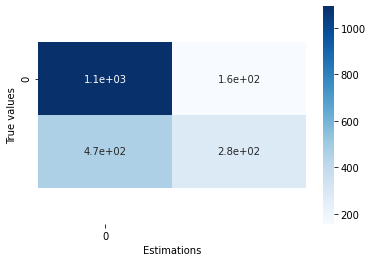

In [9]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], visualBERT['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], visualBERT['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [10]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], visualBERT['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.7257109333333334

## VisualBERT COCO

Accuracy: 0.686


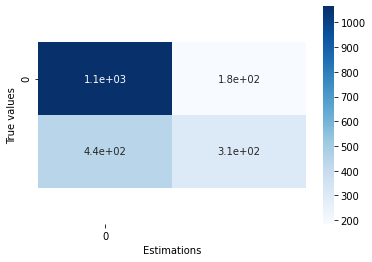

In [11]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], visualBERTCoco['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], visualBERTCoco['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [12]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], visualBERTCoco['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.7228373333333333

## ViLBERT

Accuracy: 0.4185


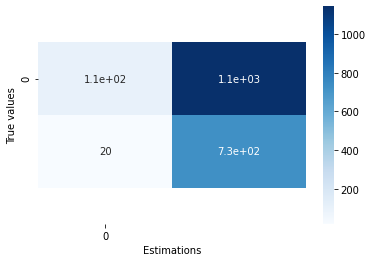

In [13]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], vilBERT['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], vilBERT['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], vilBERT['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.5294362666666668

## ERNIE-Vil

Accuracy: 0.625


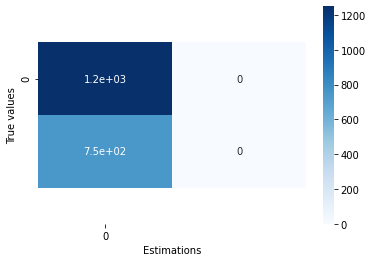

In [15]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], ernie_vil['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], ernie_vil['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], ernie_vil['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.8073365333333334

# 1st approach: Major voting
## 1.1. Hard Voting

Predict the class with the largest sum of votes from models


In [ ]:
def votingClassifier(resultsList, mode = "hard"):
  """
  resultsList: list of results. (list that contains results of each model), must be stored the results
  in label Column.
  mode:
    - hard: predict the class with the largest sum of votes from models
    - soft: predict the class with the largest summed probability from models.
  """
  newList = []
  for i in resultsList:
    newList.append(i['label'])


In [18]:
import glob
import shutil



def merge(dfs):
    return sum([df.proba.values for df in dfs]) / len(dfs)


def get_mean_predict(out_path):

    csv_list = glob.glob(visualBERT_)
    csv_list += glob.glob(visualBERTCoco_)
    csv_list += glob.glob(vilBERT_)
    csv_list += glob.glob(ernie_vil_)

    print(f"Found {len(csv_list)} csv eval result!")

    ensem_list = []
    All = False
    for csv_file in csv_list:
        # print(csv_file)
        if not All:
            yn = input(f"Include {csv_file} to ensemble? (y/n/all)")
        else:
            yn = 'y'
        yn = yn.strip().lower()
        if yn == 'all':
            All = True
        
        if yn == 'y' or All:
            ensem_list.append(csv_file)
            # dir_name = os.path.basename(os.path.dirname(csv_file))
            # shutil.copy(
            #     csv_file,
            #     os.path.join(
            #         gather_dir,
            #         f"{dir_name}_{os.path.basename(csv_file)}"
            #     )
            # )
    assert len(ensem_list) >= 2, f'You must select at least two file to ensemble, only {len(ensem_list)} is picked'
    
    base = pd.read_csv(ensem_list[0])
    print(len(ensem_list))
    ensem_list = [pd.read_csv(c) for c in ensem_list]
    base.proba = merge(ensem_list)



    # rasicm_idx = rasicm_det(
    #     os.path.join(root_dir, 'data/hateful_memes/test_unseen.jsonl'),
    #     os.path.join(root_dir, 'data/hateful_memes/box_annos.race.json'),
    #     os.path.join(root_dir, 'data/hateful_memes/img_clean'),
    # )
    # for i in rasicm_idx:
    #     base.at[int(base.index[base['id']==i].values), 'proba'] = 1.0

    base.to_csv(out_path, index=False)

In [20]:
get_mean_predict("test_set_enselble2.csv")

Found 4 csv eval result!
Include hateful_memes_run_test_2022-03-10T15_54_05.csv to ensemble? (y/n/all)y
Include hateful_memes_run_test_2022-03-11T17_00_38.csv to ensemble? (y/n/all)y
Include hateful_memes_run_test_2022-03-13T14_53_38.csv to ensemble? (y/n/all)n
Include ES365072_test_unseen_SA.csv to ensemble? (y/n/all)y
3


In [22]:
!ls

ES365072_test_unseen_SA.csv
HM_ensamble.ipynb
ensemble.py
hateful_memes_run_test_2022-03-10T15_54_05.csv
hateful_memes_run_test_2022-03-11T17_00_38.csv
hateful_memes_run_test_2022-03-13T14_53_38.csv
test_set_enselble2.csv
test_unseen.jsonl


In [23]:
result = pd.read_csv("test_set_enselble2.csv")
#result2 = pd.read_csv("test_set_enselble2.csv")

Accuracy: 0.688


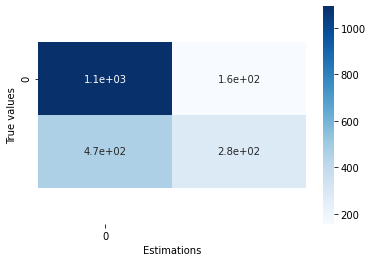

In [24]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], result['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], result['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [25]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], result['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.8084405333333334

## Second Results

Accuracy: 0.688


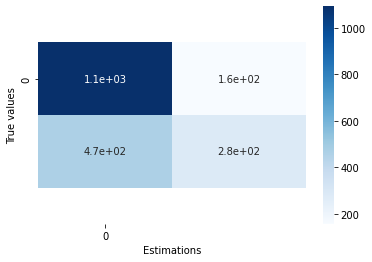

In [146]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], result2['label'], 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], result2['label'])
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [144]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], result2['proba'],  pos_label=1)
metrics.auc(fpr, tpr)

0.8088373333333332

## 2.2. Soft Voting

Predict the class with the largest summed probability from models.

# 2nd Approach: logistic regression

In [53]:
X = pd.DataFrame()
X['ernie_vil'] = ernie_vil['label']
X['visualBERT'] = visualBERT['label']
X['visualBERTCoco'] = visualBERTCoco['label']
# X['vilBERT'] = vilBERT['label']

In [54]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X, test_unseen['label'])
pred_logistic = clf.predict(X)

In [55]:
clf.score(X, test_unseen['label'])

0.6845

Accuracy: 0.6845


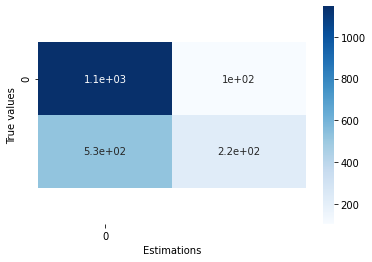

In [56]:
# Confusion Martix
plotConfusionMatrix(test_unseen['label'], pred_logistic, 2)
ConfMatrix=metrics.confusion_matrix(test_unseen['label'], pred_logistic)
print("Accuracy:", (ConfMatrix[0][0]+ConfMatrix[1][1])/2000)

In [57]:
fpr, tpr, thresholds = metrics.roc_curve(test_unseen['label'], pred_logistic,  pos_label=1)
metrics.auc(fpr, tpr)

0.6070666666666668